In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
random.seed(666)
torch.manual_seed(666)

# Load Data

In [3]:
from pathlib import Path
from npz_loader import build_episodes_from_sequences
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths, build_episodes_from_sequences

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
    Path(r"dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4"),
    Path(r"dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")
episodes = build_episodes_from_sequences(sequences_by_game)

In [4]:
sample_size = max(1, int(len(episodes) * 0.1))
sampled_episodes = random.sample(episodes, sample_size)
print(f"Sampled {len(sampled_episodes)} episodes ({len(sampled_episodes)/len(episodes)*100:.1f}% of {len(episodes)} total)")

Sampled 108 episodes (10.0% of 1080 total)


In [5]:
from episode_dataset import make_train_val_dataloaders

train_loader, val_loader, train_dataset, val_dataset = make_train_val_dataloaders(
    sampled_episodes,
    train_frac=0.9,
    timestep_window_size=4,
    image_size=(84, 84),
    batch_size=32,
)

=== Dataloader Sanity Check: TRAIN ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 4 -> {'EnduroNoFrameskip-v4': 1121, 'MsPacmanNoFrameskip-v4': 286, 'BreakoutNoFrameskip-v4': 28, 'BeamRiderNoFrameskip-v4': 165}
Actions: min=0, max=8, unique=9
Rewards: min=-1.000, max=1.000
RTG: min=-12.000, max=185.000
Reward bins: unique=[0 1 2]
RTG bins: min=2, max=199
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'EnduroNoFrameskip-v4': 1121, 'MsPacmanNoFrameskip-v4': 286, 'BreakoutNoFrameskip-v4': 28, 'BeamRiderNoFrameskip-v4': 165}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': -1.0, 'rewards_max': 1.0, 'rtg_min': -12.0, 'rtg_max': 185.0, 'reward_bins_unique': array([0, 1, 2]), 'rt

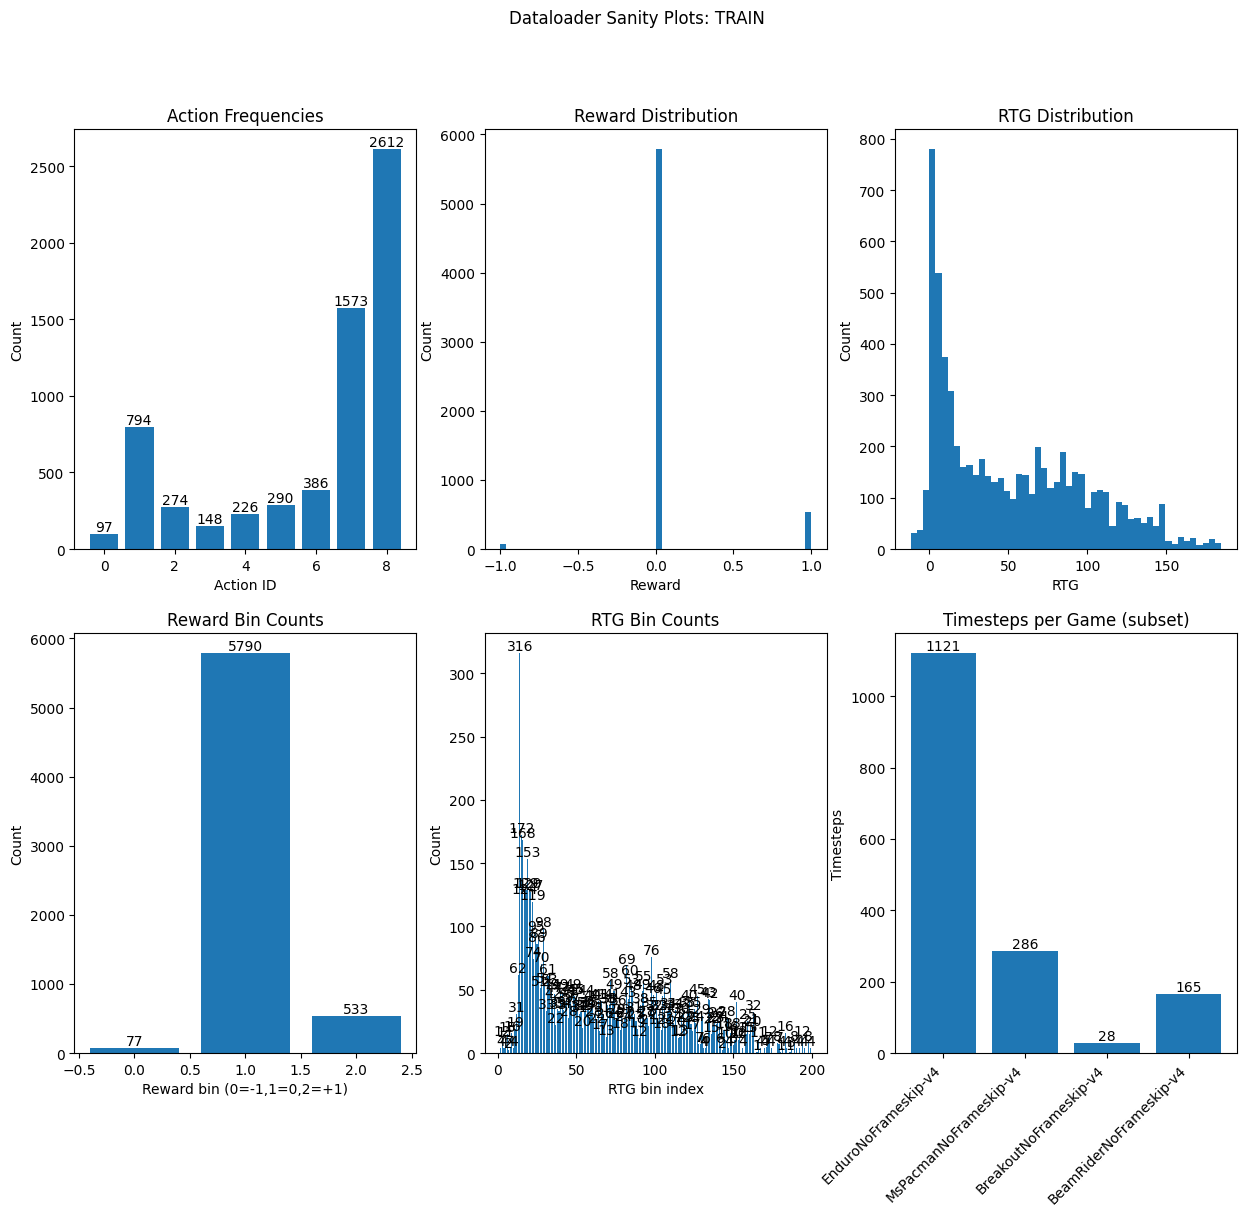

=== Dataloader Sanity Check: VAL ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 2 -> {'MsPacmanNoFrameskip-v4': 763, 'BeamRiderNoFrameskip-v4': 837}
Actions: min=0, max=8, unique=9
Rewards: min=0.000, max=1.000
RTG: min=0.000, max=122.000
Reward bins: unique=[1 2]
RTG bins: min=14, max=136
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'MsPacmanNoFrameskip-v4': 763, 'BeamRiderNoFrameskip-v4': 837}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': 0.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 122.0, 'reward_bins_unique': array([1, 2]), 'rtg_bins_min': 14, 'rtg_bins_max': 136}


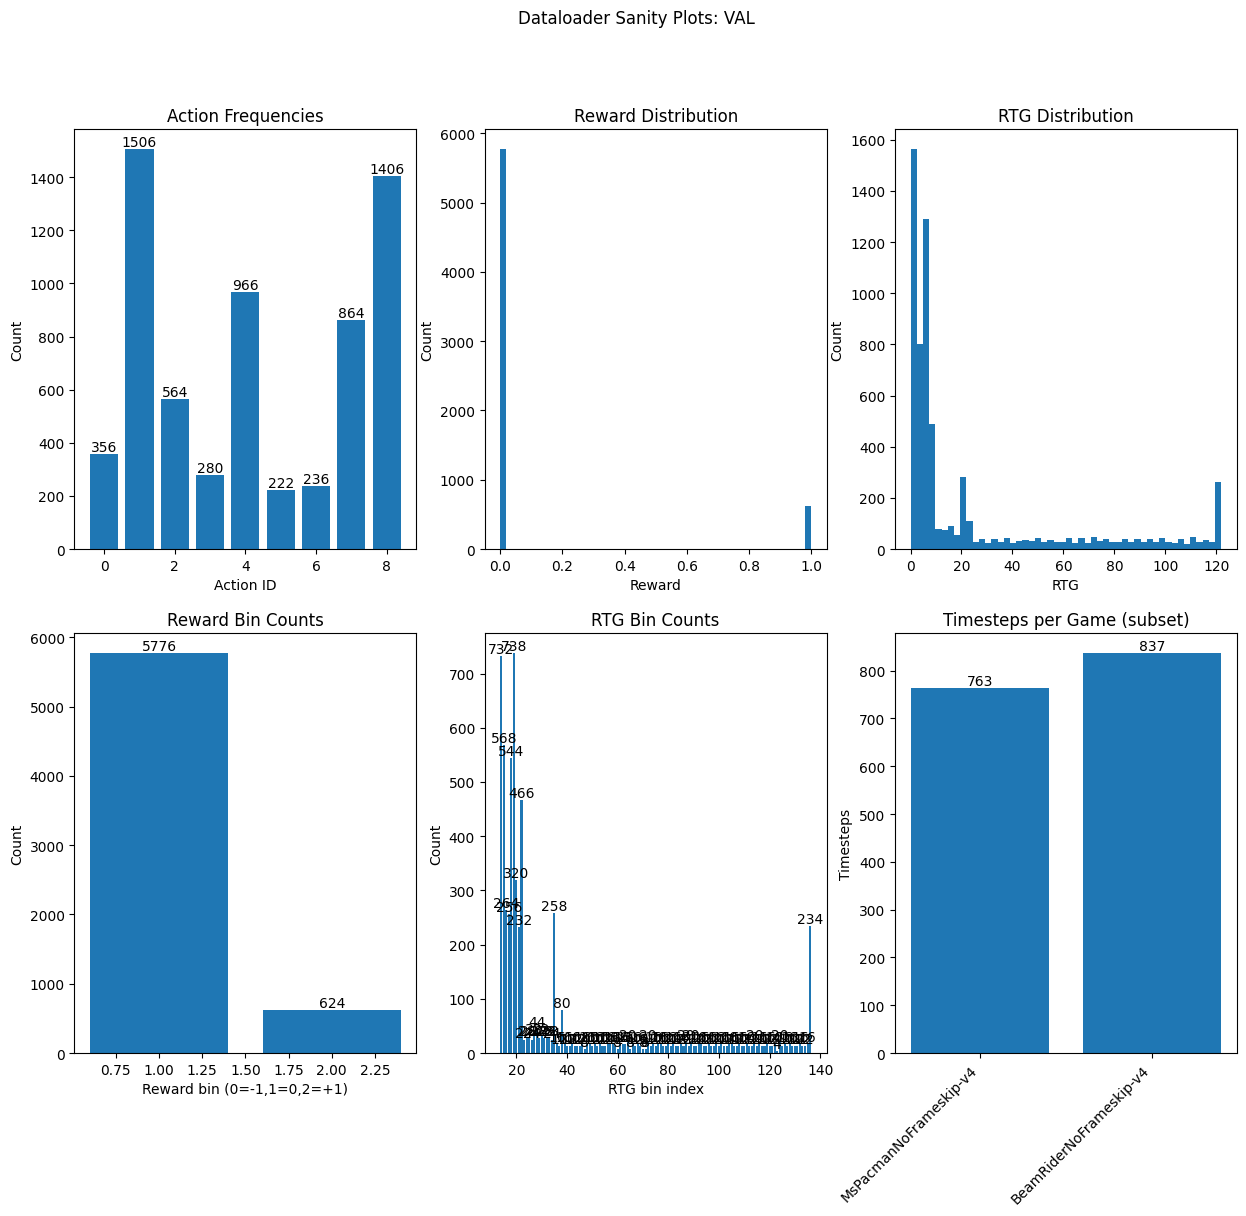

In [12]:
from dataloader_stats import inspect_dataloader

inspect_dataloader(train_loader, "TRAIN")
inspect_dataloader(val_loader, "VAL")

# Train

In [ ]:
from mgdt_model_trainer import Encoder, train_mgdt

model, train_stats, val_stats = train_mgdt(
    encoder_type=Encoder.Patch,
    episodes_train=train_dataset.episodes,
    dataset_train=train_dataset,
    dataloader_train=train_loader,
    dataloader_val=val_loader,
)

Validation: 100%|██████████| 239/239 [00:14<00:00, 16.74it/s]


# Look at Results

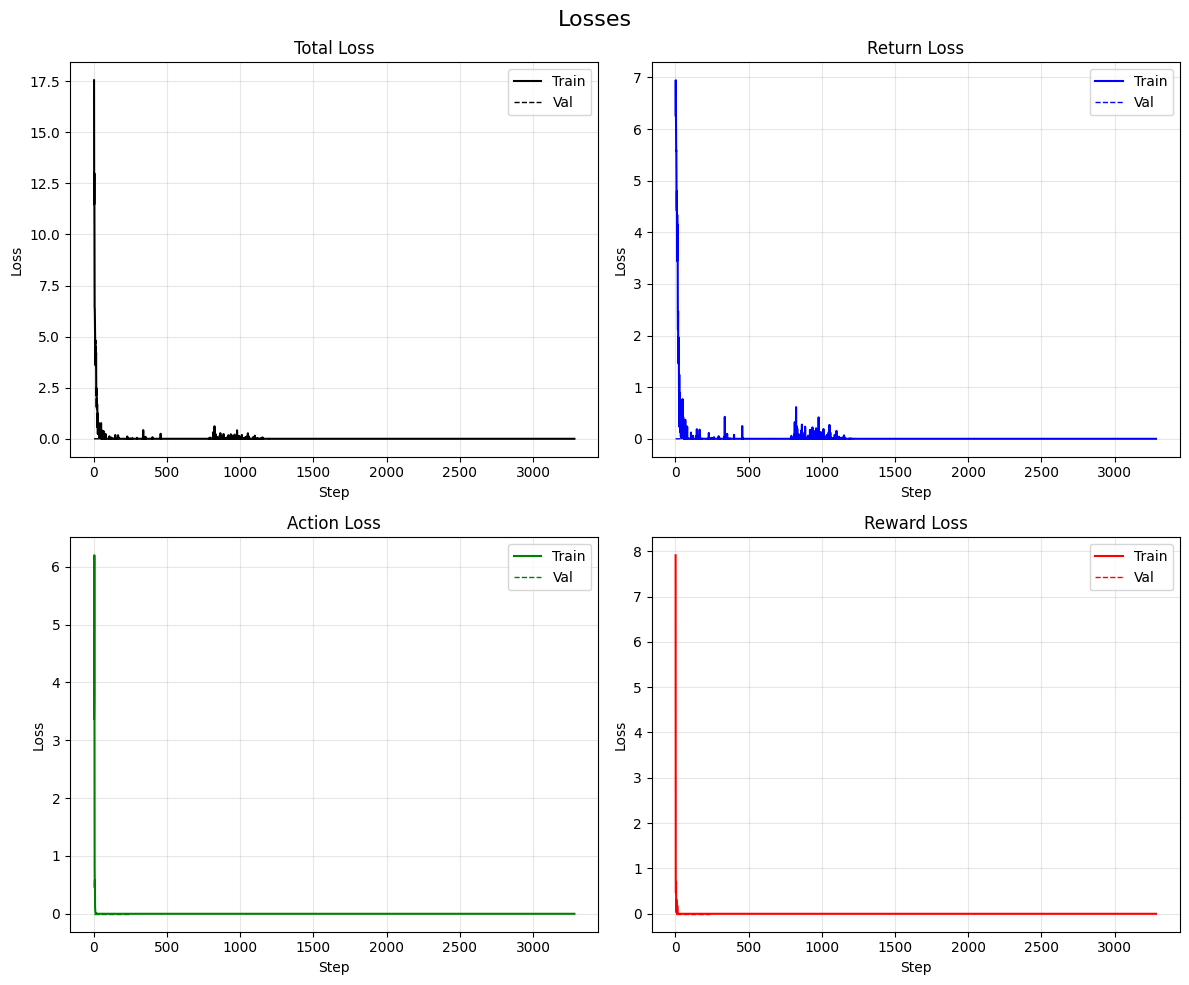

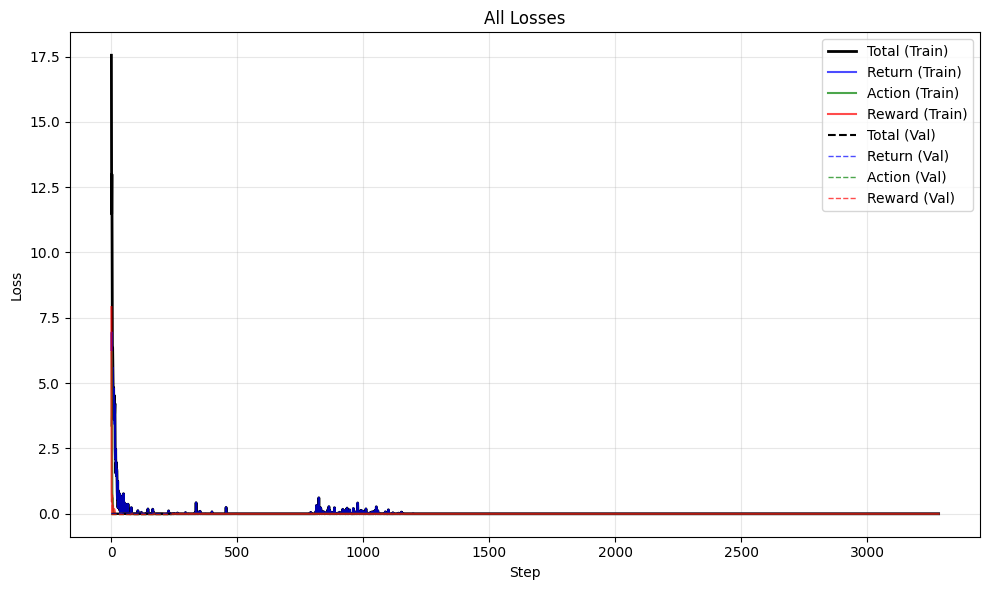

In [7]:
from mgdt_model_stats import plot_losses
plot_losses(train_stats, val_stats)

In [8]:
train_stats[:20]

[{'step': 1,
  'loss': 17.548229217529297,
  'loss_return': 6.263499736785889,
  'loss_action': 3.3748245239257812,
  'loss_reward': 7.9099040031433105,
  'ema_loss': 17.548229217529297,
  'grad_norm': 1.0000000131968965,
  'return_acc': 0.03125,
  'action_acc': 0.421875,
  'reward_acc': 0.890625,
  'random_return_ce': 5.298317366548036,
  'random_action_ce': 2.1972245773362196,
  'random_reward_ce': 1.0986122886681098},
 {'step': 2,
  'loss': 11.473654747009277,
  'loss_return': 6.944833755493164,
  'loss_action': 3.7836670875549316,
  'loss_reward': 0.7451540231704712,
  'ema_loss': 17.426737728118898,
  'grad_norm': 1.000000035336324,
  'return_acc': 0.0546875,
  'action_acc': 0.21875,
  'reward_acc': 0.90625,
  'random_return_ce': 5.298317366548036,
  'random_action_ce': 2.1972245773362196,
  'random_reward_ce': 1.0986122886681098},
 {'step': 3,
  'loss': 12.993673324584961,
  'loss_return': 6.33646297454834,
  'loss_action': 6.197014808654785,
  'loss_reward': 0.4601955711841583,


In [9]:
val_stats[:20]

[{'step': 1,
  'loss': 3.73460295577388e-07,
  'loss_return': 1.5646217832454568e-07,
  'loss_action': 2.1699810304198763e-07,
  'loss_reward': 0.0,
  'return_acc': 1.0,
  'action_acc': 1.0,
  'reward_acc': 1.0},
 {'step': 2,
  'loss': 2.998858121827652e-07,
  'loss_return': 1.2572853336223488e-07,
  'loss_action': 1.6856935758369218e-07,
  'loss_reward': 5.587935003603661e-09,
  'return_acc': 1.0,
  'action_acc': 1.0,
  'reward_acc': 1.0},
 {'step': 3,
  'loss': 4.786995759786805e-07,
  'loss_return': 1.0989602117206232e-07,
  'loss_action': 3.4179521435362403e-07,
  'loss_reward': 2.7008351111135198e-08,
  'return_acc': 1.0,
  'action_acc': 1.0,
  'reward_acc': 1.0},
 {'step': 4,
  'loss': 4.898755037174851e-07,
  'loss_return': 1.1548396372518255e-07,
  'loss_action': 3.548337872416596e-07,
  'loss_reward': 1.955777229056821e-08,
  'return_acc': 1.0,
  'action_acc': 1.0,
  'reward_acc': 1.0},
 {'step': 5,
  'loss': 5.029141547652216e-08,
  'loss_return': 3.818422200652094e-08,
  'lo